<a href="https://colab.research.google.com/github/casualcomputer/ml-stats-models/blob/main/business_process_modeling_in_R_cpu_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Markov Modeling - Sampling from continous markov chain


## 1. No parallel programming in CPU

In [ ]:
library(parallel)
library(ggplot2)

set.seed(123)  # For reproducibility

# Define the rate (generator) matrix
Q <- as.matrix(rbind(
  c(0, 0.25, 0, 0.25),
  c(0.166, 0, 0.166, 0.166),
  c(0, 0.25, 0, 0.25),
  c(0, 0, 0, 0)
))

# Define the state space
states <- 1:nrow(Q)

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q) {
  rates <- Q[current_state, ]
  if (sum(rates) == 0) {
    return(current_state)  # Stay in the current state if no transitions are possible
  }
  probs <- rates / sum(rates)
  return(sample(states, size = 1, prob = probs))
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q) {
  rate <- sum(Q[current_state, ])
  if (rate == 0) {
    return(Inf)  # Infinite holding time if no transitions are possible
  }
  return(rexp(1, rate = rate))
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q, n_transitions, initial_state) {
  current_state <- initial_state
  current_time <- 0
  sequence_of_states <- c(current_state)
  transition_times <- c(current_time)

  for (i in 1:n_transitions) {
    ht <- holding_time(current_state, Q)
    if (ht == Inf) {
      break  # Stop if holding time is infinite
    }
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  return(data.frame(Time = transition_times, State = sequence_of_states))
}

# Parameters
n_simulations <- 1000000
n_transitions <- 100
initial_state <- 1

# Start time
start_time <- Sys.time()

# List to store results of all simulations
all_simulations <- list()

# Generate multiple series
for (i in 1:n_simulations) {
  sim_result <- simulate_markov_chain(Q, n_transitions, initial_state)
  sim_result$Simulation <- i  # Add a column to identify the simulation
  all_simulations[[i]] <- sim_result
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# End time
end_time <- Sys.time()

# Calculate and print runtime
run_time <- end_time - start_time
print(paste("Start time:", start_time))
print(paste("End time:", end_time))
print(paste("Run time:", run_time))

# Print the combined results summary
summary(combined_results)

# Plot the state sequences for all simulations
# library(ggplot2)
# ggplot(combined_results, aes(x = Time, y = State, color = factor(Simulation))) +
#   geom_step() +
#   labs(title = "Multiple Continuous-Time Markov Chain Simulations",
#        x = "Time",
#        y = "State",
#        color = "Simulation") +
#   theme_minimal()

[1] "Start time: 2024-06-16 03:39:34.692605"
[1] "End time: 2024-06-16 03:45:06.328434"
[1] "Run time: 5.52726381619771"


      Time            State         Simulation     
 Min.   : 0.000   Min.   :1.000   Min.   :      1  
 1st Qu.: 0.000   1st Qu.:1.000   1st Qu.: 249877  
 Median : 1.489   Median :2.000   Median : 499818  
 Mean   : 3.237   Mean   :2.308   Mean   : 499911  
 3rd Qu.: 4.745   3rd Qu.:4.000   3rd Qu.: 749926  
 Max.   :63.556   Max.   :4.000   Max.   :1000000  

## 2. Parallel programming in CPU

In [ ]:
library(parallel)
library(ggplot2)

set.seed(123)  # For reproducibility

# Start time
start_time <- Sys.time()

# Set up parallel execution
n_cores <- detectCores() - 1  # Use one less than the number of available cores
cl <- makeCluster(n_cores)

# Export necessary objects and functions to the cluster
clusterExport(cl, c("Q", "n_transitions", "initial_state", "states", "next_state", "holding_time", "simulate_markov_chain"))

# Use parLapply to execute the simulation function in parallel
all_simulations <- parLapply(cl, 1:n_simulations, function(x) {
  sim_result <- simulate_markov_chain(Q, n_transitions, initial_state)
  sim_result$Simulation <- x  # Add a column to identify the simulation
  return(sim_result)
})

# Stop the cluster
stopCluster(cl)

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# End time
end_time <- Sys.time()

# Calculate and print runtime
run_time <- end_time - start_time
print(paste("Start time:", start_time))
print(paste("End time:", end_time))
print(paste("Run time:", run_time))

# Print the combined results summary
summary(combined_results)

[1] "Start time: 2024-06-16 03:45:06.812621"
[1] "End time: 2024-06-16 03:50:21.123162"
[1] "Run time: 5.23850901126862"


      Time            State         Simulation     
 Min.   : 0.000   Min.   :1.000   Min.   :      1  
 1st Qu.: 0.000   1st Qu.:1.000   1st Qu.: 250199  
 Median : 1.486   Median :2.000   Median : 499987  
 Mean   : 3.234   Mean   :2.308   Mean   : 499998  
 3rd Qu.: 4.736   3rd Qu.:4.000   3rd Qu.: 749741  
 Max.   :61.780   Max.   :4.000   Max.   :1000000  

## 3. GPU accelerated with Tensorflow - not working

In [ ]:
devtools::install_github("rstudio/keras")
#install.packages("keras")
# reticulate: Reticulate: R Interface to Python
# tfruns: Track and Visualize Training Runs
# zeallot: multiple, unpacking, destructuring assignments w/ %<-% operator

rlang      (1.1.3  -> 1.1.4 ) [CRAN]
backports  (1.4.1  -> 1.5.0 ) [CRAN]
rstudioapi (0.15.0 -> 0.16.0) [CRAN]
tidyselect (1.2.0  -> 1.2.1 ) [CRAN]
whisker    (0.4    -> 0.4.1 ) [CRAN]
processx   (3.8.3  -> 3.8.4 ) [CRAN]
fastmap    (1.1.1  -> 1.2.0 ) [CRAN]


Installing 7 packages: rlang, backports, rstudioapi, tidyselect, whisker, processx, fastmap

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpyHF7K8/remotes3a0480451b1/rstudio-keras3-fa07f20/DESCRIPTION’ ... OK
* preparing ‘keras3’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘keras3_1.0.0.9000.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
install.packages("keras")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# Define the rate (generator) matrix
Q <- matrix(c(
  0, 0.25, 0, 0.25,
  0.166, 0, 0.166, 0.166,
  0, 0.25, 0, 0.25,
  0, 0, 0, 0),
  nrow = 4, byrow = TRUE
)

# Convert Q to a TensorFlow constant
Q_tf <- tf$constant(Q, dtype = tf$float32)

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q_tf) {
  rates <- Q_tf[current_state, ]
  probs <- rates / tf$reduce_sum(rates)
  sample <- tf$random$categorical(tf$log(tf$reshape(probs, shape = c(1, -1))), num_samples = 1)
  return(tf$cast(sample, tf$int32) + 1L)
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q_tf) {
  rate <- tf$reduce_sum(Q_tf[current_state, ])
  ht <- tf$random$exponential(shape = list(), rate = rate)
  return(ht)
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q_tf, n_transitions, initial_state) {
  current_state <- initial_state - 1L  # Adjust for 0-indexing in TensorFlow
  current_time <- 0.0
  sequence_of_states <- list(current_state)
  transition_times <- list(current_time)

  for (i in seq_len(n_transitions)) {
    ht <- holding_time(current_state, Q_tf)
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q_tf)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  df <- data.frame(
    Time = as.numeric(unlist(transition_times)),
    State = as.integer(unlist(sequence_of_states)) + 1  # Adjust back to 1-indexing
  )
  return(df)
}

# Parameters
n_simulations <- 1000000
n_transitions <- 100
initial_state <- 1

# Start time
start_time <- Sys.time()

# Generate multiple series
all_simulations <- vector("list", n_simulations)
for (i in seq_len(n_simulations)) {
  all_simulations[[i]] <- simulate_markov_chain(Q_tf, n_transitions, initial_state)
  all_simulations[[i]]$Simulation <- i
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# End time
end_time <- Sys.time()

# Calculate and print runtime
run_time <- end_time - start_time
print(paste("Start time:", start_time))
print(paste("End time:", end_time))
print(paste("Run time:", run_time))

# Print the combined results summary
summary(combined_results)

# Plot the state sequences for all simulations
# library(ggplot2)
# ggplot(combined_results, aes(x = Time, y = State, color = factor(Simulation))) +
#   geom_step() +
#   labs(title = "Multiple Continuous-Time Markov Chain Simulations",
#        x = "Time",
#        y = "State",
#        color = "Simulation") +
#   theme_minimal()


ERROR: Error: Valid installation of TensorFlow not found.

Python environments searched for 'tensorflow' package:
 /usr/bin/python3.10

Python exception encountered:
 Traceback (most recent call last):
  File "/usr/local/lib/R/site-library/reticulate/python/rpytools/loader.py", line 122, in _find_and_load_hook
    return _run_hook(name, _hook)
  File "/usr/local/lib/R/site-library/reticulate/python/rpytools/loader.py", line 96, in _run_hook
    module = hook()
  File "/usr/local/lib/R/site-library/reticulate/python/rpytools/loader.py", line 120, in _hook
    return _find_and_load(name, import_)
ModuleNotFoundError: No module named 'tensorflow'


You can install TensorFlow using the install_tensorflow() function.



## 3. GPU accelerated with PyTorch: not working

In [ ]:
# Install reticulate package to interface with Python
install.packages("reticulate")
library(reticulate)

# Use reticulate to interface with Python
use_python("/usr/bin/python3")  # Specify the path to your Python interpreter
py_install("torch", pip = TRUE)

# Load the PyTorch library via reticulate
torch <- import("torch")

# Define the rate (generator) matrix
Q <- matrix(c(
  0, 0.25, 0, 0.25,
  0.166, 0, 0.166, 0.166,
  0, 0.25, 0, 0.25,
  0, 0, 0, 0),
  nrow = 4, byrow = TRUE
)

# Convert Q to a PyTorch tensor and move to GPU
Q_torch <- torch$from_numpy(Q)$float()$cuda()

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q_torch) {
  rates <- Q_torch[current_state, ]
  probs <- rates / rates$sum()
  sample <- torch$multinomial(probs, 1)
  return(sample$item())
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q_torch) {
  rate <- Q_torch[current_state, ]$sum()
  ht <- torch$distributions$Exponential(rate)$sample()
  return(ht$item())
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q_torch, n_transitions, initial_state) {
  current_state <- initial_state - 1  # Adjust for 0-indexing in PyTorch
  current_time <- 0.0
  sequence_of_states <- list(current_state)
  transition_times <- list(current_time)

  for (i in seq_len(n_transitions)) {
    ht <- holding_time(current_state, Q_torch)
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q_torch)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  df <- data.frame(
    Time = unlist(transition_times),
    State = unlist(sequence_of_states) + 1  # Adjust back to 1-indexing
  )
  return(df)
}

# Parameters
n_simulations <- 10
n_transitions <- 100
initial_state <- 1

# Start time
start_time <- Sys.time()

# Generate multiple series
all_simulations <- vector("list", n_simulations)
for (i in seq_len(n_simulations)) {
  all_simulations[[i]] <- simulate_markov_chain(Q_torch, n_transitions, initial_state)
  all_simulations[[i]]$Simulation <- i
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# End time
end_time <- Sys.time()

# Calculate and print runtime
run_time <- end_time - start_time
print(paste("Run time:", run_time))

# Print the combined results summary
summary(combined_results)

# Plot the state sequences for all simulations
library(ggplot2)
ggplot(combined_results, aes(x = Time, y = State, color = factor(Simulation))) +
  geom_step() +
  labs(title = "Multiple Continuous-Time Markov Chain Simulations",
       x = "Time",
       y = "State",
       color = "Simulation") +
  theme_minimal()


# Modeling business process using Markov Chains

## visNetwork (not working)

In [10]:
set.seed(123)  # For reproducibility

# Define the rate (generator) matrix
Q <- as.matrix(rbind(
  c(0, 0.25, 0, 0.25),
  c(0.166, 0, 0.166, 0.166),
  c(0, 0.25, 0, 0.25),
  c(0, 0, 0, 0)
))

# Define the state space
states <- 1:nrow(Q)

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q) {
  rates <- Q[current_state, ]
  if (sum(rates) == 0) {
    return(current_state)  # Stay in the current state if no transitions are possible
  }
  probs <- rates / sum(rates)
  return(sample(states, size = 1, prob = probs))
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q) {
  rate <- sum(Q[current_state, ])
  if (rate == 0) {
    return(Inf)  # Infinite holding time if no transitions are possible
  }
  return(rexp(1, rate = rate))
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q, n_transitions, initial_state) {
  current_state <- initial_state
  current_time <- 0
  sequence_of_states <- c(current_state)
  transition_times <- c(current_time)

  for (i in 1:n_transitions) {
    ht <- holding_time(current_state, Q)
    if (ht == Inf) {
      break  # Stop if holding time is infinite
    }
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  return(data.frame(Time = transition_times, State = sequence_of_states))
}

# Parameters
n_simulations <- 1000
n_transitions <- 100
initial_state <- 1

# List to store results of all simulations
all_simulations <- list()

# Generate multiple series
for (i in 1:n_simulations) {
  sim_result <- simulate_markov_chain(Q, n_transitions, initial_state)
  sim_result$Simulation <- i  # Add a column to identify the simulation
  all_simulations[[i]] <- sim_result
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# Create an edgelist with average holding times and transition frequencies
library(dplyr)

# Generate the transition times correctly
combined_results <- combined_results %>%
  group_by(Simulation) %>%
  mutate(NextState = lead(State),
         NextTime = lead(Time)) %>%
  filter(!is.na(NextState))

edges <- combined_results %>%
  group_by(State, NextState) %>%
  summarize(AverageTime = mean(NextTime - Time), Transitions = n(), .groups = 'drop')

# Calculate transition probabilities
total_transitions <- sum(edges$Transitions)
edges <- edges %>%
  mutate(Probability = Transitions / total_transitions)

# Calculate average holding time per state
node_list <- combined_results %>%
  group_by(State) %>%
  summarize(AverageHoldingTime = mean(NextTime - Time, na.rm = TRUE), .groups = 'drop')

# Visualize the process map using visNetwork
library(visNetwork)

nodes <- data.frame(
  id = states,
  label = paste("State", states),
  value = node_list$AverageHoldingTime[match(states, node_list$State)],  # Node size based on holding time
  shape = "ellipse"
)

edges <- data.frame(
  from = edges$State,
  to = edges$NextState,
  label = paste0("Time: ", round(edges$AverageTime, 2),
                 "\nProb: ", round(edges$Probability, 2)),
  value = edges$Transitions,  # Edge darkness based on transition frequency
  arrows = "to"
)

print(edges)

visNetwork(nodes, edges) %>%
  visEdges(arrows = "to",
           color = list(color = "lightblue", highlight = "red"),
           scaling = list(label = list(enabled = TRUE), min = 1, max = 5)) %>%
  visNodes(scaling = list(label = list(enabled = TRUE), min = 10, max = 50)) %>%
  visOptions(highlightNearest = TRUE) %>%
  visInteraction(navigationButtons = TRUE) %>%
  visPhysics(stabilization = FALSE)

  from to                  label value arrows
1    1  2 Time: 2.01\nProb: 0.29   658     to
2    1  4 Time: 1.94\nProb: 0.27   601     to
3    2  1 Time: 1.99\nProb: 0.11   259     to
4    2  3  Time: 1.92\nProb: 0.1   225     to
5    2  4 Time: 1.97\nProb: 0.13   294     to
6    3  2 Time: 2.08\nProb: 0.05   120     to
7    3  4 Time: 2.13\nProb: 0.05   105     to


## igraph: the most frequent transitions visually (% of total transitions)

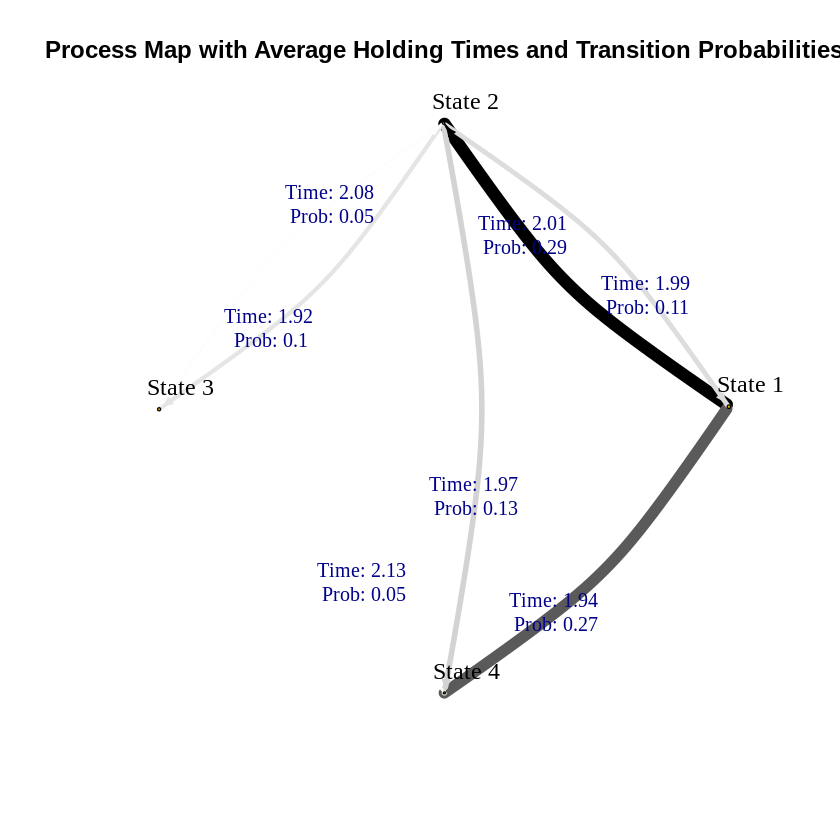

In [64]:
library(igraph)
library(dplyr)

set.seed(123)  # For reproducibility

# Define the rate (generator) matrix
Q <- as.matrix(rbind(
  c(0, 0.25, 0, 0.25),
  c(0.166, 0, 0.166, 0.166),
  c(0, 0.25, 0, 0.25),
  c(0, 0, 0, 0)
))

# Define the state space
states <- 1:nrow(Q)

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q) {
  rates <- Q[current_state, ]
  if (sum(rates) == 0) {
    return(current_state)  # Stay in the current state if no transitions are possible
  }
  probs <- rates / sum(rates)
  return(sample(states, size = 1, prob = probs))
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q) {
  rate <- sum(Q[current_state, ])
  if (rate == 0) {
    return(Inf)  # Infinite holding time if no transitions are possible
  }
  return(rexp(1, rate = rate))
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q, n_transitions, initial_state) {
  current_state <- initial_state
  current_time <- 0
  sequence_of_states <- c(current_state)
  transition_times <- c(current_time)

  for (i in 1:n_transitions) {
    ht <- holding_time(current_state, Q)
    if (ht == Inf) {
      break  # Stop if holding time is infinite
    }
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  return(data.frame(Time = transition_times, State = sequence_of_states))
}

# Parameters
n_simulations <- 1000
n_transitions <- 100
initial_state <- 1

# List to store results of all simulations
all_simulations <- list()

# Generate multiple series
for (i in 1:n_simulations) {
  sim_result <- simulate_markov_chain(Q, n_transitions, initial_state)
  sim_result$Simulation <- i  # Add a column to identify the simulation
  all_simulations[[i]] <- sim_result
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# Create an edgelist with average holding times and transition frequencies

# Generate the transition times correctly
combined_results <- combined_results %>%
  group_by(Simulation) %>%
  mutate(NextState = lead(State),
         NextTime = lead(Time)) %>%
  filter(!is.na(NextState))

edges <- combined_results %>%
  group_by(State, NextState) %>%
  summarize(AverageTime = mean(NextTime - Time), Transitions = n(), .groups = 'drop')

# Calculate transition probabilities
total_transitions <- sum(edges$Transitions)
edges <- edges %>%
  mutate(Probability = Transitions / total_transitions)

# Calculate average holding time per state
node_list <- combined_results %>%
  group_by(State) %>%
  summarize(AverageHoldingTime = mean(diff(Time)), .groups = 'drop')

# Create a unified vertex list from both State and NextState
unique_states <- unique(c(edges$State, edges$NextState))
vertex_list <- data.frame(State = unique_states) %>%
  left_join(node_list, by = c("State" = "State")) %>%
  mutate(AverageHoldingTime = ifelse(is.na(AverageHoldingTime), 0, AverageHoldingTime))

# Create a graph using igraph

# Create igraph object
g <- graph_from_data_frame(d = edges, vertices = vertex_list, directed = TRUE)

# Set vertex size based on average holding time
V(g)$size <- sqrt(V(g)$AverageHoldingTime) * 20  # Adjust scaling for better visualization

# Set edge width based on transition frequency
E(g)$width <- E(g)$Transitions / max(E(g)$Transitions) * 10  # Adjust scaling for better visualization

# Set edge color based on transition probability (higher probability -> darker color)
E(g)$color <- gray.colors(100, start = 1, end = 0)[as.numeric(cut(E(g)$Probability, breaks = 100))]

# Set labels for vertices
V(g)$label <- paste("State", V(g)$name)

# Identifying important states
# Plot the graph using a layout to minimize overlapping
plot(g,
     layout = layout_with_kk(g),
     edge.arrow.size = 0.5,
     vertex.label.cex = 1.2,  # Increase font size for better readability
     vertex.label.dist = 1.5,
     main = "Process Map with Average Holding Times and Transition Probabilities",
     vertex.label.color = "black",
     edge.label = paste("Time:", round(E(g)$AverageTime, 2), "\nProb:", round(E(g)$Probability, 2)),
     edge.label.cex = 1,  # Increase font size for edge labels
     edge.curved = 0.2,  # Add curvature to edges
     edge.color = E(g)$color)  # Set the edge color


## igraph: the most frequent transitions visually (count)

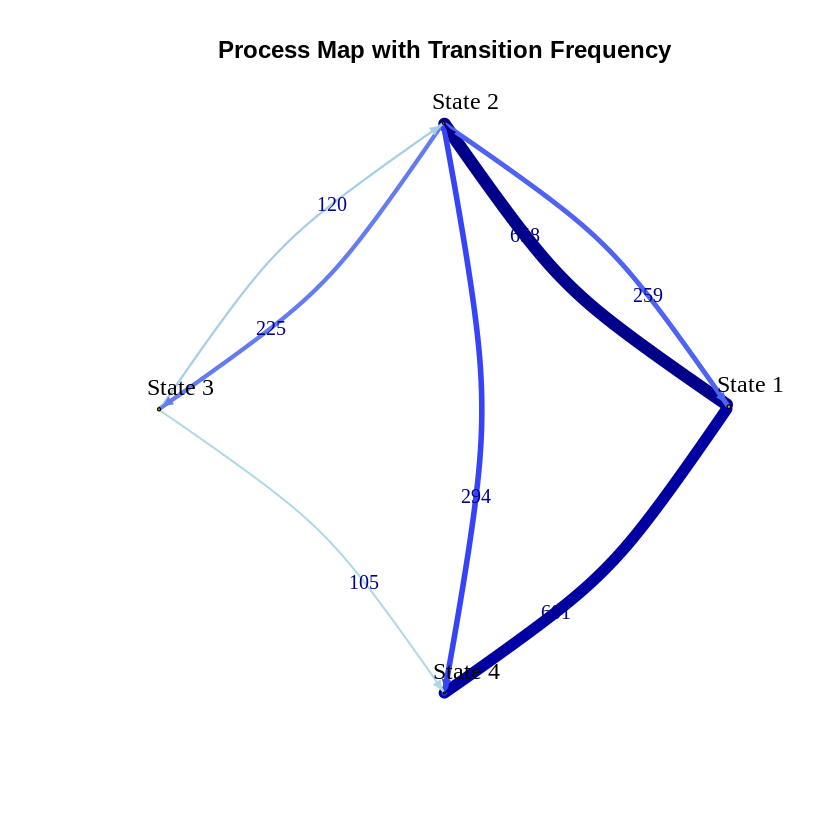

In [51]:
library(igraph)
library(dplyr)
library(grDevices)

set.seed(123)  # For reproducibility

# Define the rate (generator) matrix
Q <- as.matrix(rbind(
  c(0, 0.25, 0, 0.25),
  c(0.166, 0, 0.166, 0.166),
  c(0, 0.25, 0, 0.25),
  c(0, 0, 0, 0)
))

# Define the state space
states <- 1:nrow(Q)

# Function to choose the next state based on current state and rate matrix
next_state <- function(current_state, Q) {
  rates <- Q[current_state, ]
  if (sum(rates) == 0) {
    return(current_state)  # Stay in the current state if no transitions are possible
  }
  probs <- rates / sum(rates)
  return(sample(states, size = 1, prob = probs))
}

# Function to determine the holding time based on the current state
holding_time <- function(current_state, Q) {
  rate <- sum(Q[current_state, ])
  if (rate == 0) {
    return(Inf)  # Infinite holding time if no transitions are possible
  }
  return(rexp(1, rate = rate))
}

# Function to simulate a single Markov chain sequence
simulate_markov_chain <- function(Q, n_transitions, initial_state) {
  current_state <- initial_state
  current_time <- 0
  sequence_of_states <- c(current_state)
  transition_times <- c(current_time)

  for (i in 1:n_transitions) {
    ht <- holding_time(current_state, Q)
    if (ht == Inf) {
      break  # Stop if holding time is infinite
    }
    current_time <- current_time + ht
    current_state <- next_state(current_state, Q)

    sequence_of_states <- c(sequence_of_states, current_state)
    transition_times <- c(transition_times, current_time)
  }

  return(data.frame(Time = transition_times, State = sequence_of_states))
}

# Parameters
n_simulations <- 1000
n_transitions <- 100
initial_state <- 1

# List to store results of all simulations
all_simulations <- list()

# Generate multiple series
for (i in 1:n_simulations) {
  sim_result <- simulate_markov_chain(Q, n_transitions, initial_state)
  sim_result$Simulation <- i  # Add a column to identify the simulation
  all_simulations[[i]] <- sim_result
}

# Combine all simulations into a single data frame
combined_results <- do.call(rbind, all_simulations)

# Create an edgelist with average holding times and transition frequencies

# Generate the transition times correctly
combined_results <- combined_results %>%
  group_by(Simulation) %>%
  mutate(NextState = lead(State),
         NextTime = lead(Time)) %>%
  filter(!is.na(NextState))

edges <- combined_results %>%
  group_by(State, NextState) %>%
  summarize(AverageTime = mean(NextTime - Time), Transitions = n(), .groups = 'drop')

# Calculate transition probabilities
total_transitions <- sum(edges$Transitions)
edges <- edges %>%
  mutate(Probability = Transitions / total_transitions,
         Weight = Transitions)  # Set Weight as the frequency of the edge pair

# Calculate average holding time per state
node_list <- combined_results %>%
  group_by(State) %>%
  summarize(AverageHoldingTime = mean(diff(Time)), .groups = 'drop')

# Create a unified vertex list from both State and NextState
unique_states <- unique(c(edges$State, edges$NextState))
vertex_list <- data.frame(State = unique_states) %>%
  left_join(node_list, by = c("State" = "State")) %>%
  mutate(AverageHoldingTime = ifelse(is.na(AverageHoldingTime), 0, AverageHoldingTime))

# Create a graph using igraph
g <- graph_from_data_frame(d = edges, vertices = vertex_list, directed = TRUE)

# Set vertex size based on average holding time
V(g)$size <- sqrt(V(g)$AverageHoldingTime) * 20  # Adjust scaling for better visualization

# Set edge width based on the new weight (frequency of edge pair)
E(g)$width <- E(g)$Weight / max(E(g)$Weight) * 10  # Adjust scaling for better visualization

# Create a custom color palette with better contrast
color_palette <- colorRampPalette(c("lightblue", "blue", "darkblue"))(100)
E(g)$color <- color_palette[as.numeric(cut(E(g)$Probability, breaks = 100))]

# Set labels for vertices
V(g)$label <- paste("State", V(g)$name)

# Plot the graph using a layout to minimize overlapping
plot(g,
     layout = layout_with_kk(g),
     edge.arrow.size = 0.5,
     vertex.label.cex = 1.2,  # Increase font size for better readability
     vertex.label.dist = 1.5,
     main = "Process Map with Transition Frequency",
     vertex.label.color = "black",
     edge.label = E(g)$Weight,  # Label with the frequency of transitions
     edge.label.cex = 1,  # Increase font size for edge labels
     edge.curved = 0.2,  # Add curvature to edges
     edge.color = E(g)$color)  # Set the edge color


## igraph: find the shortest path

In [57]:
# Function to find the shortest path using Dijkstra's algorithm
find_shortest_path <- function(graph, source, target) {
  # Find the shortest path
  sp <- shortest_paths(graph, from = as.character(source), to = as.character(target), weights = E(graph)$Weight, mode = "out")
  return(sp)
}

# Define source and target nodes
source <- 1
target <- 4

# Find the shortest path from source to target
shortest_path <- find_shortest_path(g, source, target)

# Extract the vertices and edges in the shortest path
shortest_path_vertices <- V(g)[shortest_path$vpath[[1]]]
shortest_path_edges <- E(g, path = shortest_path$vpath[[1]])

# Print the shortest path vertices and edges
print(shortest_path_vertices)  # Vertices in the shortest path
print(shortest_path_edges)     # Edges in the shortest path

# Print the shortest path in a readable format
cat("Shortest path from", source, "to", t arget, "is:\n")
cat(paste(shortest_path_vertices$name, collapse = " -> "), "\n")
cat("Total weight: ", sum(E(g, path = shortest_path$vpath[[1]])$Weight), "\n")

+ 2/4 vertices, named, from ea25f66:
[1] 1 4
+ 1/7 edge from ea25f66 (vertex names):
[1] 1->4
Shortest path from 1 to 4 is:
1 -> 4 
Total weight:  601 


## igraph: find the longest path (not working)

In [61]:
# Check if the graph is a DAG
if (!is_dag(g)) {
  stop("The graph is not a Directed Acyclic Graph (DAG). Longest path calculation requires a DAG.")
}

find_longest_path <- function(graph, source, target) {
  # Negate the weights
  E(graph)$negWeight <- -E(graph)$Weight

  # Find the shortest path with the negated weights
  sp <- shortest_paths(graph, from = as.character(source), to = as.character(target), weights = E(graph)$negWeight, mode = "out")
  return(sp)
}

# Define source and target nodes
source <- 1
target <- 4

# Find the longest path from source to target
longest_path <- find_longest_path(g, source, target)

# Extract the vertices and edges in the longest path
longest_path_vertices <- V(g)[longest_path$vpath[[1]]]
longest_path_edges <- E(g, path = longest_path$vpath[[1]])

# Print the longest path vertices and edges
print(longest_path_vertices)  # Vertices in the longest path
print(longest_path_edges)     # Edges in the longest path

# Print the longest path in a readable format
cat("Longest path from", source, "to", target, "is:\n")
cat(paste(longest_path_vertices$name, collapse = " -> "), "\n")
cat("Total weight: ", sum(-E(g, path = longest_path$vpath[[1]])$negWeight), "\n")  # Negate back the weights to get the original values


ERROR: Error in eval(expr, envir, enclos): The graph is not a Directed Acyclic Graph (DAG). Longest path calculation requires a DAG.


## Sort paths by length (frequency of subprocess)

In [63]:
# Function to find all paths from source to target
find_all_paths <- function(graph, source, target) {
  all_paths <- all_simple_paths(graph, from = as.character(source), to = as.character(target), mode = "out")
  return(all_paths)
}

# Function to calculate the weight of a path
calculate_path_weight <- function(graph, path) {
  edges <- E(graph, path = path)
  total_weight <- sum(E(graph)[edges]$Weight)
  return(total_weight)
}

# Define source and target nodes
source <- 1
target <- 4

# Find all paths from source to target
all_paths <- find_all_paths(g, source, target)

# Calculate weights for all paths
path_weights <- sapply(all_paths, function(path) calculate_path_weight(g, path))

# Combine paths and their weights into a data frame
path_info <- data.frame(
  path = I(all_paths),
  weight = path_weights
)

# Sort paths by weight (longest to shortest)
sorted_paths <- path_info %>% arrange(desc(weight))

# Print the sorted paths and their weights
cat("Paths from", source, "to", target, "sorted by weight (longest to shortest):\n")
for (i in 1:nrow(sorted_paths)) {
  path <- sorted_paths$path[[i]]
  weight <- sorted_paths$weight[i]
  cat(paste(V(g)[path]$name, collapse = " -> "), "with total weight:", weight, "\n")
}


Paths from 1 to 4 sorted by weight (longest to shortest):
1 -> 2 -> 3 -> 4 with total weight: 988 
1 -> 2 -> 4 with total weight: 952 
1 -> 4 with total weight: 601 


# TO-DO: questions to ponder

* TO-DO: do we account for the initial distribution of markov chain? e.g. if there is a 33.4% percent chance of being in state 1,2,3 equally. shouldn't there be an equal number of simulations in each of state 1, 2, and 3?

* TO-DO: unbiased estimator of this approach? does it matter if there is no stationary distribution? how do we account for non-stationary distributions? can we do the same simulations with state-space model? Is the ODE in space-state models a good assumption for modeling process (what about higher-order derivations)? does it make sense to generate the sequences by some variable x, model the most frequent sequences for each level of x, and claim that these processes are in fact data-generating process for each level of x (e.g. here is the most frequent process for male and female)? how do we estimate confidence interval or introduce this concept? if a continous and discrete markov process give different results, how do we reconcile? how do we justify discrete vs. continous (and associated optimization challenges)? how do we know if the modeling through msm makes sense (failed to converge; if it converge, it could still fail to describe the buisness process). how do we demonstrate markov chain is just a special case of graphical models? how do we model the total variance of the sum of individual transition time (summing up to total time it takes for transitions to take place from source to target states)?

* TO-DO: check of if there is deterministic/closed form solutions for finding or approximating the most frequent sequences

* TO-DO: compare simulation results of both discrete and continous process

* TO-DO: the gpu-accelerated implementation is not working yet

* TO-DO: produce an animation to show the data generating process (state transition, time)
